In [4]:
from jax import numpy as np
from numpy import random

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})
sns.set_style('ticks')

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [6]:
from scipy.special import erfc
def H(x):
    return erfc(x/np.sqrt(2))/2

$$ SNR = \frac{\|\Delta x_0\|^2 + (R_b^2 R_a^{-2} - 1)/m}{\sqrt{D^{-1}/m + \|\Delta x_0 \cdot U_a\|^2 + \|\Delta x_0 \cdot U_b\|^2 / m}} $$

In [179]:
def SNR(signal, bias, D, overlap, m):
    return 1/2*(signal + bias/m) / np.sqrt(1/D/m + overlap*(1+1/m) + 1/D/m**2)

In [173]:
N = 500
D = 50
P = 5000

def few_shot_err(N,D,P,m,Ra,Rb,theta=np.pi/2):
    # Subspaces
    U = random.randn(N,2*(D+1))
    U,_ = np.linalg.qr(U)
    Ua,Ub,x0a,x0b = np.split(U,(D,2*D,2*D+1),axis=-1)
    
    # Center-subspace overlaps
    x0a = np.sin(theta)*x0a + np.cos(theta)*Ua.sum(-1,keepdims=True) / np.sqrt(D)
    x0a /= np.sqrt(2)
    x0b = np.sin(theta)*x0b + np.cos(theta)*Ub.sum(-1,keepdims=True) / np.sqrt(D)
    x0b /= np.sqrt(2)

    # Training examples
    sa = random.randn(D,P,m) / np.sqrt(D)
#     sa /= np.linalg.norm(sa,axis=0)
    sb = random.randn(D,P,m) / np.sqrt(D)
#     sb /= np.linalg.norm(sb,axis=0)
    Xatrain = x0a + Ra*Ua@sa.mean(-1)
    Xbtrain = x0b + Rb*Ub@sb.mean(-1)
    Xtrain = np.stack([Xatrain,Xbtrain])

    # Testing examples
    ssa = random.randn(D,P) / np.sqrt(D)
#     ssa /= np.linalg.norm(ssa,axis=0)
    ssb = random.randn(D,P) / np.sqrt(D)
#     ssb /= np.linalg.norm(ssb,axis=0)
    Xatest = x0a + Ra*Ua@ssa
    Xbtest = x0b + Rb*Ub@ssb

    # Evaluate
    da = ((Xatest - Xtrain)**2).sum(1)
#     db = ((Xbtest - Xtrain)**2).sum(1)
    erra = (da.argmin(0)!=0).mean()
#     errb = (db.argmin(0)!=1).mean()
#     err = (erra+errb)/2
    
    return erra


def few_shot_err_m_infinity(N,D,P,m,Ra,Rb,theta=np.pi/2):
    # Subspaces
    U = random.randn(N,2*(D+1))
    U,_ = np.linalg.qr(U)
    Ua,Ub,x0a,x0b = np.split(U,(D,2*D,2*D+1),axis=-1)
    
    # Center-subspace overlaps
    x0a = np.sin(theta)*x0a + np.cos(theta)*Ua.sum(-1,keepdims=True) / np.sqrt(D)
    x0a /= np.sqrt(2)
    x0b = np.sin(theta)*x0b + np.cos(theta)*Ub.sum(-1,keepdims=True) / np.sqrt(D)
    x0b /= np.sqrt(2)

    # Training examples
    Xtrain = np.stack([x0a,x0b])

    # Testing examples
    ssa = random.randn(D,P) / np.sqrt(D)
#     ssa /= np.linalg.norm(ssa,axis=0)
    ssb = random.randn(D,P) / np.sqrt(D)
#     ssb /= np.linalg.norm(ssb,axis=0)
    Xatest = x0a + Ra*Ua@ssa
    Xbtest = x0b + Rb*Ub@ssb

    # Evaluate
    da = ((Xatest - Xtrain)**2).sum(1)
#     db = ((Xbtest - Xtrain)**2).sum(1)
    erra = (da.argmin(0)!=0).mean()
#     errb = (db.argmin(0)!=1).mean()
#     err = (erra+errb)/2
    
    return erra

# Spheres

In [174]:
ms = [1,3,5]
Rs = 1/np.linspace(0.4,1,20)
errs = []
for m in ms:
    for R in tqdm(Rs):
        Ra = Rb = R
        err = few_shot_err(N,D,P,m,Ra,Rb)
        errs.append(err)
errs_signal = np.stack(errs).reshape(len(ms),len(Rs))

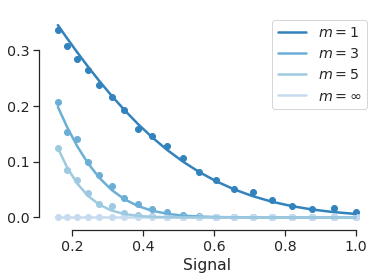

In [176]:
with sns.color_palette('tab20c'):
    for err,m in zip(errs_signal,ms):
        plt.scatter((1/Rs)**2,err)
        bias = 0
        overlap = 0
        signals = (1/Rs)**2
        plt.plot(signals, H(SNR(signals, bias, D, overlap, m)), label=r'$m=$'+str(m))
        
    # m->infty
    plt.scatter((1/Rs)**2,np.zeros_like(Rs))
    plt.plot(signals, H(SNR(signals, bias, D, overlap, 1000)), label=r'$m=\infty$', zorder=-1)
#         plt.yscale('log')
plt.xlabel('Signal')
plt.legend()
sns.despine(trim=True);
# plt.savefig('images/geometry_components_signal.pdf')

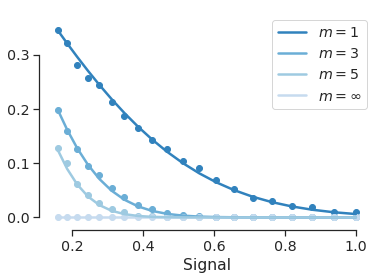

In [74]:
with sns.color_palette('tab20c'):
    for err,m in zip(errs_signal,ms):
        plt.scatter((1/Rs)**2,err)
        bias = 0
        overlap = 0
        signals = (1/Rs)**2
        plt.plot(signals, H(SNR(signals, bias, D, overlap, m)), label=r'$m=$'+str(m))
        
    # m->infty
    plt.scatter((1/Rs)**2,np.zeros_like(Rs))
    plt.plot(signals, H(SNR(signals, bias, D, overlap, 1000)), label=r'$m=\infty$', zorder=-1)
#         plt.yscale('log')
plt.xlabel('Signal')
plt.legend()
sns.despine(trim=True);
# plt.savefig('images/geometry_components_signal.pdf')

In [183]:
ms = [1,3,5]
R = 2
Ra = Rb = R
Ds = np.linspace(10,200,20,dtype='int')
errs = []
for m in ms:
    for D in tqdm(Ds):
        err = few_shot_err(N,D,P,m,Ra,Rb)
        errs.append(err)
errs_dim = np.stack(errs).reshape(len(ms),len(Ds))

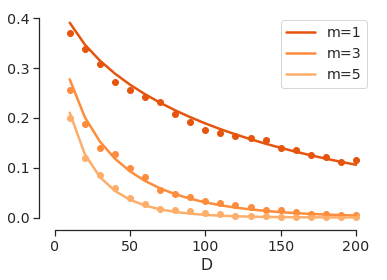

In [184]:
with sns.color_palette('tab20c'):
    for i in range(4):
        plt.scatter(0,0,s=0)
        plt.plot(0,0)
    for err,m in zip(errs_dim,ms):
        plt.scatter(Ds,err)
        bias = 0
        overlap = 0
        signal = 1/R**2
        plt.plot(Ds, H(SNR(signal, bias, Ds, overlap, m)), label='m='+str(m))
# plt.yscale('log')
plt.xlabel('D')
plt.legend()
sns.despine(trim=True);
# plt.savefig('images/geometry_components_dimension.pdf')

In [185]:
# Bias
ms = [1,3,5]
R = 2
D = 50
Ra = R
biases = np.linspace(-1,1,20)
Rbs = np.sqrt(biases+1)*Ra

errs = []
for m in ms:
    for Rb in tqdm(Rbs):
        err = few_shot_err(N,D,P,m,Ra,Rb)
        errs.append(err)
errs_bias = np.stack(errs).reshape(len(ms),len(Rs))

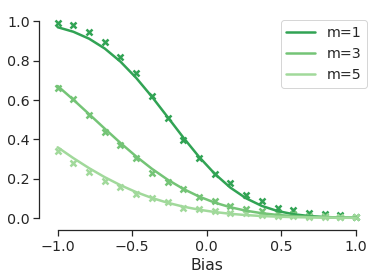

In [186]:
with sns.color_palette('tab20c',):
    for i in range(8):
        plt.scatter(0,0,s=0)
        plt.plot(0,0)
    for err,m in zip(errs_bias,ms):
        plt.scatter(biases,err,marker='x')
        overlap = 0
        signal = 1/R**2
        plt.plot(biases, H(SNR(signal, biases, D, overlap, m)), label='m='+str(m))
# plt.yscale('log')
plt.xlabel('Bias')
plt.legend()
sns.despine(trim=True);
# plt.savefig('images/geometry_components_bias.pdf')

In [215]:
err

array([0.0264    , 0.0318    , 0.0286    , 0.0336    , 0.0372    ,
       0.0336    , 0.0316    , 0.0414    , 0.045     , 0.0514    ,
       0.0572    , 0.0572    , 0.07340001, 0.0678    , 0.0722    ,
       0.0762    , 0.0828    , 0.07700001, 0.07520001, 0.0824    ],
      dtype=float32)

In [232]:
thetas = np.linspace(np.pi/2,np.pi,20)
R = 1.5
D = 25
navg = 10
Ra = Rb = R
errs = []
for m in ms:
    for theta in tqdm(thetas):
        errtmp = []
        for _ in range(navg):
            
            err = few_shot_err(N,D,P,m,Ra,Rb,theta)
            errtmp.append(err)
        errs.append(np.mean(np.stack(errtmp)))

# m->infty
for theta in tqdm(thetas):
    err = few_shot_err_m_infinity(N,D,P,m,Ra,Rb,theta)
    errs.append(err)
errs_overlap = np.stack(errs).reshape(len(ms)+1,len(Rs))

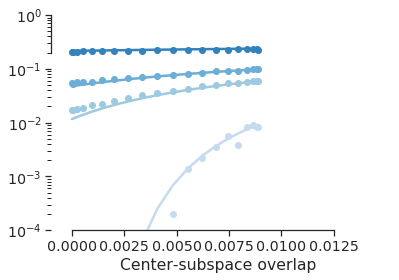

In [233]:
with sns.color_palette('tab20c'):
    for err,m in zip(errs_overlap,ms):
        overlaps = np.cos(thetas)**2/(2*D*R**2)
        plt.scatter(overlaps,err)
        bias = 0
        signal = 1/R**2
        plt.plot(overlaps, H(SNR(signal, bias, D, overlaps, m)), label='m='+str(m))
#         plt.yscale('log')
plt.scatter(overlaps,errs_overlap[-1])
plt.plot(overlaps, H(SNR(signal, bias, D, overlaps, 1e6)), label=r'$m=\infty$',zorder=-1)
plt.xlabel('Center-subspace overlap')
# plt.legend()
plt.xlim([-0.001,0.015])
# plt.xlim([-0.0004,0.0055])
plt.ylim([1e-4,1.1])
sns.despine(trim=True);

plt.yscale('log')
# plt.savefig('images/geometry_components_center_subspace.pdf')

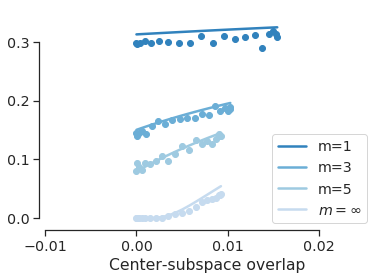

In [130]:
with sns.color_palette('tab20c'):
    for err,m in zip(errs_overlap,ms):
        overlaps = np.cos(thetas)**2/(2*D*R**2)*(1+1/m)
        plt.scatter(overlaps,err)
        bias = 0
        signal = 1/R**2
        plt.plot(overlaps, H(SNR(signal, bias, D, overlaps, m)), label='m='+str(m))
#         plt.yscale('log')
plt.scatter(overlaps,errs_overlap[-1])
plt.plot(overlaps, H(SNR(signal, bias, D, overlaps, 1e6)), label=r'$m=\infty$',zorder=-1)
plt.xlabel('Center-subspace overlap')
plt.legend()
# plt.xlim([-0.001,0.016])
# plt.xlim([-0.0004,0.0055])
sns.despine(trim=True);
# plt.savefig('images/geometry_components_center_subspace.pdf')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

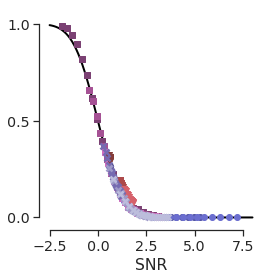

In [187]:
cmap = plt.cm.get_cmap('tab20c')
cmapb = plt.cm.get_cmap('tab20b')

plt.figure(figsize=(4,4))
x = np.linspace(-2.5,8,100)
plt.plot(x,H(x), c='black',zorder=-99, linewidth=2)

m = 1
bias = 0
overlap = 0
signals = (1/Rs)**2
for i,m in enumerate(ms):
    plt.scatter(SNR(signals, bias, D, overlap, m), errs_signal[i], c=cmapb(i))

# Dimension
signal = 1/R**2
for i,m in enumerate(ms):
    plt.scatter(SNR(signal, bias, Ds, overlap, m), errs_dim[i], marker='x', c=cmap(i+12), zorder=99)

# Bias
for i,m in enumerate(ms):
    plt.scatter(SNR(signal, biases, D, overlap, m), errs_bias[i], marker='s', c=cmapb(i+16))

overlaps = np.cos(thetas)**2/(2*D*R**2)*(1+1/m)
for i,m in enumerate(ms):
    plt.scatter(SNR(signal, bias, D, overlaps, m), errs_overlap[i], marker='v', c=cmapb(i+12))

plt.yticks([0,0.5,1])
sns.despine(trim=True)
plt.xlabel('SNR');

# plt.savefig('images/geometry_components_SNR.pdf')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

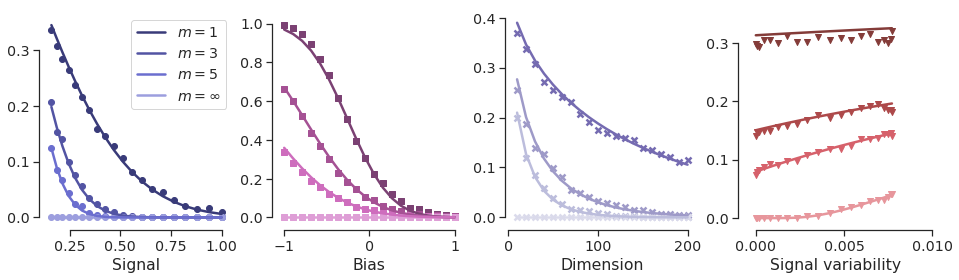

In [192]:
cmap = plt.cm.get_cmap('tab20c')
cmapb = plt.cm.get_cmap('tab20b')

R = 2
D = 50
plt.figure(figsize=(16,4))
plt.subplot(141)
m = 1
bias = 0
overlap = 0
signals = (1/Rs)**2
for i,m in enumerate(ms):
    plt.scatter(signals, errs_signal[i], c=cmapb(i))
    plt.plot(signals, H(SNR(signals, bias, D, overlap, m)), label=r'$m=$'+str(m), c=cmapb(i))
# m->infinity
plt.scatter(signals, np.zeros_like(signals), c=cmapb(i+1))
plt.plot(signals, H(SNR(signals, bias, D, overlap, 1e6)), label=r'$m=\infty$', c=cmapb(i+1),zorder=-1)
plt.legend()
plt.xlabel('Signal')

plt.subplot(143)
# Dimension
signal = 1/R**2
for i,m in enumerate(ms):
    plt.scatter(Ds, errs_dim[i], marker='x', c=cmap(i+12))
    plt.plot(Ds, H(SNR(signal, bias, Ds, overlap, m)), label=r'$m=$'+str(m), c=cmap(i+12))
# m->infinity
plt.scatter(Ds, np.zeros_like(Ds), c=cmap(i+12+1), marker='x')
plt.plot(Ds, H(SNR(signal, bias, Ds, overlap, 1e6)), label=r'$m=\infty$', c=cmap(i+12+1),zorder=-1)
plt.xlabel('Dimension')
# plt.legend()

plt.subplot(142)
# Bias
for i,m in enumerate(ms):
    plt.scatter(biases,errs_bias[i], marker='s', c=cmapb(i+16))
    plt.plot(biases, H(SNR(signal, biases, D, overlap, m)), label=r'$m=$'+str(m), c=cmapb(i+16))
# m->infinity
plt.scatter(biases, np.zeros_like(biases), c=cmapb(i+16+1), marker='s')
plt.plot(biases, H(SNR(signal, biases, D, overlap, 1e6)), label=r'$m=\infty$', c=cmapb(i+16+1),zorder=-1)
plt.xlabel('Bias')
# plt.legend()

plt.subplot(144)

D = 20
R = 1.8
signal = 1/R**2
for i,m in enumerate(ms):
    overlaps = np.cos(thetas)**2/(2*D*R**2)
    plt.scatter(overlaps,errs_overlap[i], marker='v', c=cmapb(i+12))
    plt.plot(overlaps,H(SNR(signal, bias, D, overlaps, m)), label=r'$m=$'+str(m), c=cmapb(i+12))
#     plt.xlim([-0.0004,0.0055])
    plt.xlim([-0.002,0.025])
    plt.xlim([-0.001,0.01])
    plt.xlabel('Signal variability')
plt.scatter(overlaps,errs_overlap[-1], marker='v', c=cmapb(i+12+1))
plt.plot(overlaps, H(SNR(signal, bias, D, overlaps, 1e6)), label=r'$m=\infty$', c=cmapb(i+12+1),zorder=-1)
# plt.legend()

sns.despine(trim=True)
# plt.savefig('images/geometry_components.pdf')

# Ellipsoids

In [97]:
Dsvd = (Ra**2).sum()**2 / (Ra**4).sum()
print(Dsvd)
m = 5

53.260616


In [101]:
Ra *= 5
Rb *= 5

In [102]:
erra = few_shot_err(N,D,P,m,Ra,Rb,theta=np.pi/2)

In [103]:
erra

DeviceArray(0.36560002, dtype=float32)

In [236]:
N = 2100
D = 1000
alpha = 0.5
Rs = np.arange(1,D+1)**(-alpha)
Rs /= np.sqrt((Rs**2).mean())
Dsvd = (Rs**2).sum()**2 / (Rs**4).sum()

In [237]:
Dsvd

DeviceArray(34.08426, dtype=float32)

In [123]:
ms = [1,3,5]
Rvals = 1/np.linspace(0.4,1,20)
errs = []
Dsvds = []
for m in ms:
    for R in tqdm(Rvals):
        Ra = Rb = R*Rs
        err = few_shot_err(N,D,P,m,Ra,Rb)
        errs.append(err)
errs_signal = np.stack(errs).reshape(len(ms),len(Rvals))

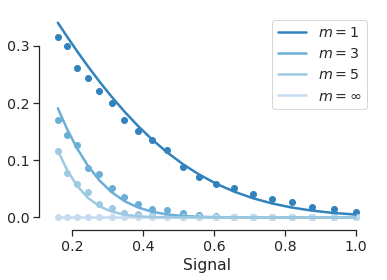

In [124]:
with sns.color_palette('tab20c'):
    for err,m in zip(errs_signal,ms):
        plt.scatter((1/Rvals)**2,err)
        bias = 0
        overlap = 0
        signals = (1/Rvals)**2
        plt.plot(signals, H(SNR(signals, bias, Dsvd, overlap, m)), label=r'$m=$'+str(m))
        
    # m->infty
    plt.scatter((1/Rvals)**2,np.zeros_like(Rvals))
    plt.plot(signals, H(SNR(signals, bias, D, overlap, 1000)), label=r'$m=\infty$', zorder=-1)
#         plt.yscale('log')
plt.xlabel('Signal')
plt.legend()
sns.despine(trim=True);
# plt.savefig('images/geometry_components_signal.pdf')

In [127]:
alpha

0.3

In [159]:

def few_shot_err(N,D,P,m,Ra,Rb,theta=np.pi/2):
    # Subspaces
    U = random.randn(N,2*(D+1))
    U,_ = np.linalg.qr(U)
    Ua,Ub,x0a,x0b = np.split(U,(D,2*D,2*D+1),axis=-1)
    
    # Center-subspace overlaps
    x0a = np.sin(theta)*x0a + np.cos(theta)*Ua.sum(-1,keepdims=True) / np.sqrt(D)
    x0a /= np.sqrt(2)
    x0b = np.sin(theta)*x0b + np.cos(theta)*Ub.sum(-1,keepdims=True) / np.sqrt(D)
    x0b /= np.sqrt(2)

    # Training examples
    sa = random.randn(D,P,m) / np.sqrt(D)
    sa /= np.linalg.norm(sa,axis=0)
    sb = random.randn(D,P,m) / np.sqrt(D)
    sb /= np.linalg.norm(sb,axis=0)
    Xatrain = x0a + Ra*Ua@sa.mean(-1)
    Xbtrain = x0b + Rb*Ub@sb.mean(-1)
    Xtrain = np.stack([Xatrain,Xbtrain])

    # Testing examples
    ssa = random.randn(D,P) / np.sqrt(D)
    ssa /= np.linalg.norm(ssa,axis=0)
    ssb = random.randn(D,P) / np.sqrt(D)
    ssb /= np.linalg.norm(ssb,axis=0)
    Xatest = x0a + Ra*Ua@ssa
    Xbtest = x0b + Rb*Ub@ssb

    # Evaluate
    da = ((Xatest - Xtrain)**2).sum(1)
#     db = ((Xbtest - Xtrain)**2).sum(1)
    erra = (da.argmin(0)!=0).mean()
#     errb = (db.argmin(0)!=1).mean()
#     err = (erra+errb)/2
    
    return erra



In [243]:
alpha = 0.4
Rs = np.arange(1,D+1)**(-alpha)
Rs /= np.sqrt((Rs**2).mean())
Dsvd = (Rs**2).sum()**2 / (Rs**4).sum()
print(Dsvd)

105.92167


In [244]:
N = 2100
D = 1000
alphas = np.linspace(0.4,0.55,20)
Rs = np.arange(1,D+1)**(-alpha)
Rs /= np.sqrt((Rs**2).mean())
Dsvd = (Rs**2).sum()**2 / (Rs**4).sum()

ms = [1,3,5]
R = 2
Ds = []
errs = []
for m in ms:
    for alpha in tqdm(alphas):
        Rs = np.arange(1,D+1)**(-alpha)
        Rs /= np.sqrt((Rs**2).mean())
        Dsvd = (Rs**2).sum()**2 / (Rs**4).sum()
        Ds.append(Dsvd)
        Ra = Rb = 2*Rs
        err = few_shot_err(N,D,P,m,Ra,Rb)
        errs.append(err)
errs_dim = np.stack(errs).reshape(len(ms),len(alphas))
Ds = np.stack(Ds).reshape(len(ms),len(alphas))[0]

In [253]:
def SNR(signal, bias, D, overlap, m):
    return 1/2*(signal + bias/m) / np.sqrt(1/D/m + overlap + 1/D/m**2)

In [ ]:
with sns.color_palette('tab20c'):
    for i in range(4):
        plt.scatter(0,0,s=0)
        plt.plot(0,0)
    for err,m in zip(errs_dim,ms):
        plt.scatter(Ds,err)
        bias = 0
        overlap = 0
        signal = 1/R**2
        plt.plot(Ds, H(SNR(signal, bias, Ds, overlap, m)), label='m='+str(m))
# plt.yscale('log')
plt.xlabel('D')
plt.legend()
sns.despine(trim=True);
# plt.savefig('images/geometry_components_dimension.pdf')

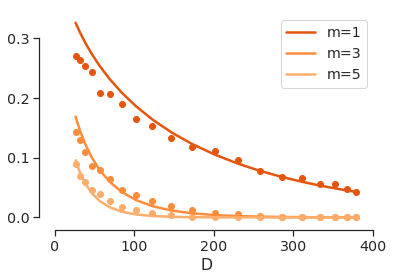

In [145]:
with sns.color_palette('tab20c'):
    for i in range(4):
        plt.scatter(0,0,s=0)
        plt.plot(0,0)
    for err,m in zip(errs_dim,ms):
        plt.scatter(Ds,err)
        bias = 0
        overlap = 0
        signal = 1/R**2
        plt.plot(Ds, H(SNR(signal, bias, Ds, overlap, m)), label='m='+str(m))
# plt.yscale('log')
plt.xlabel('D')
plt.legend()
sns.despine(trim=True);
# plt.savefig('images/geometry_components_dimension.pdf')

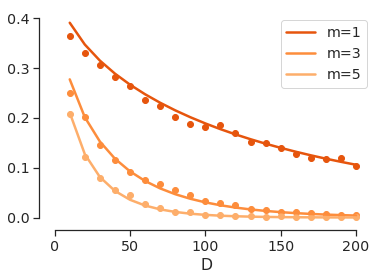

In [76]:
with sns.color_palette('tab20c'):
    for i in range(4):
        plt.scatter(0,0,s=0)
        plt.plot(0,0)
    for err,m in zip(errs_dim,ms):
        plt.scatter(Ds,err)
        bias = 0
        overlap = 0
        signal = 1/R**2
        plt.plot(Ds, H(SNR(signal, bias, Ds, overlap, m)), label='m='+str(m))
# plt.yscale('log')
plt.xlabel('D')
plt.legend()
sns.despine(trim=True);
# plt.savefig('images/geometry_components_dimension.pdf')

In [122]:
Dsvd

DeviceArray(53.260616, dtype=float32)

# Evaluating approximations

In [72]:
Rs = np.load('/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/resnet50/Rs.npy')

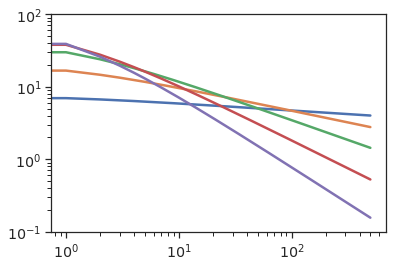

In [1122]:
N = 500
alphas = np.linspace(0.1,1,5)

Ds = []
for alpha in alphas:
    R = 100*np.arange(1,N+1)**(-alpha)
    R /= np.sqrt(np.sum(R**2))
    R *= 100
    plt.plot(R)
    Ds.append(np.sum(R**2)**2 / np.sum(R**4))
    
R0 = Rs[0]
R0 /= np.sqrt(np.sum(R0**2))
R0 *= 100
plt.plot(R0)
plt.xscale('log')
plt.ylim(1e-1,100)
plt.yscale('log')

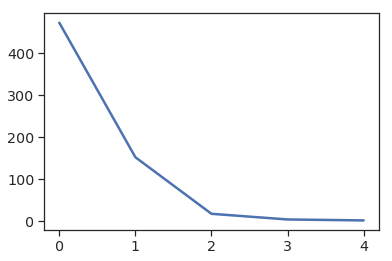

In [1123]:
plt.plot(Ds)

In [1124]:
N = 500
P = 10000

s = random.randn(P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)

In [1197]:
N = 500
s = random.randn(P,N) / np.sqrt(N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)

ss = random.randn(P,N) / np.sqrt(N)
ss /= np.linalg.norm(ss,axis=-1,keepdims=True)

variances = []
var2s = []
means = []
Ds = []
alphas = np.linspace(0.1,2,20)
for alpha in alphas:
    R = 100*np.arange(1,N+1)**(-alpha)
    R /= np.sqrt(np.sum(R**2))
    R *= 50
    Ds.append(np.sum(R**2)**2 / np.sum(R**4))
    variances.append(np.var(np.sum((R*s)**2,axis=-1)))
    means.append(np.mean(np.sum(R**2*s**2,axis=-1)))
    var2s.append(np.var(np.sum(R**2*s*ss,axis=-1)))
Ds = np.stack(Ds)
moments = np.stack(moments)

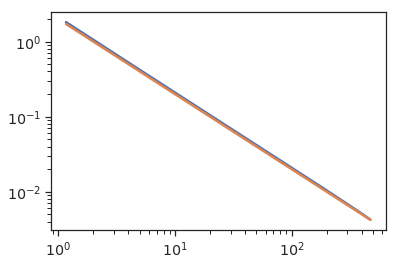

In [1198]:
plt.plot(Ds, np.stack(variances) / np.mean(R**2)**2)
plt.plot(Ds, 2/Ds)
plt.xscale('log')
plt.yscale('log')

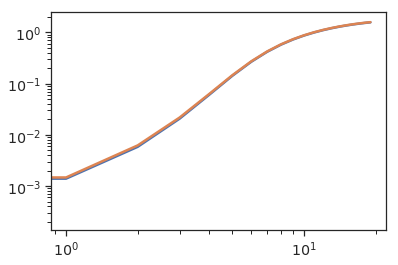

In [1184]:
plt.plot(moments / np.mean(R**2)**2 - 1)
plt.plot(np.stack(variances) / np.mean(R**2)**2)
plt.yscale('log')
plt.xscale('log')

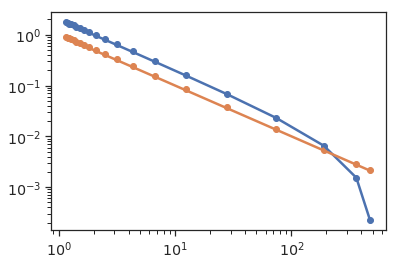

In [1142]:
plt.scatter(Ds,np.stack(variances) / np.mean(R**2)**2)
plt.plot(Ds,2*(1/Ds - 1/N))

plt.scatter(Ds,np.stack(var2s) / np.mean(R**2)**2)
plt.plot(Ds,1/Ds)
plt.yscale('log')
plt.xscale('log')

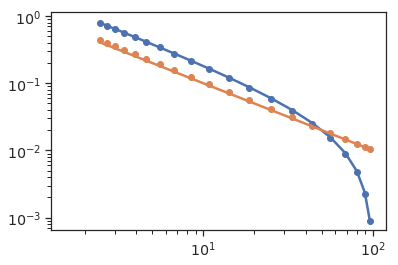

In [517]:
plt.scatter(Ds,np.stack(variances) / np.mean(R**2)**2)
plt.plot(Ds,2*(1/Ds - 1/N))

plt.scatter(Ds,np.stack(var2s) / np.mean(R**2)**2)
plt.plot(Ds,1/Ds)
plt.yscale('log')
plt.xscale('log')

In [174]:
alpha = 0.1
R = 100*np.arange(1,N+1)**(-alpha)
R /= np.sqrt(np.sum(R**2))
R *= 100

s = random.randn(P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)

ss = random.randn(P,N)
ss /= np.linalg.norm(ss,axis=-1,keepdims=True)

(array([  32.,  360., 1530., 2858., 2831., 1570.,  604.,  165.,   41.,
           9.]),
 array([19.043566, 19.274017, 19.50447 , 19.734922, 19.965374, 20.195827,
        20.42628 , 20.65673 , 20.887182, 21.117636, 21.348087],
       dtype=float32),
 <a list of 10 Patch objects>)

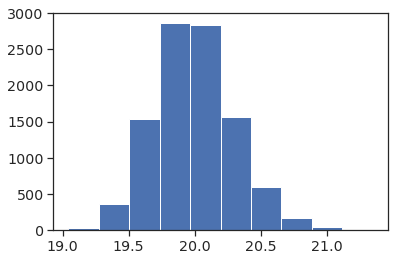

In [173]:
plt.hist(np.sum((R*s)**2,axis=-1))

(array([   7.,   56.,  356., 1231., 2387., 3001., 1937.,  808.,  190.,
          27.]),
 array([-3.6919875 , -2.9979742 , -2.3039606 , -1.6099472 , -0.9159337 ,
        -0.22192025,  0.4720932 ,  1.1661067 ,  1.86012   ,  2.5541337 ,
         3.248147  ], dtype=float32),
 <a list of 10 Patch objects>)

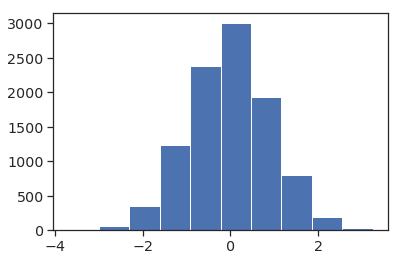

In [175]:
plt.hist(np.sum(R**2*s*ss,axis=-1))

In [176]:
np.var(np.sum(R**2*s*ss,axis=-1))

DeviceArray(0.84888744, dtype=float32)

# Investigations

In [1306]:
N = 500
D = 500
P = 5000

def few_shot_err(N,D,P,m,Ra,Rb,theta=np.pi/2):
    # Subspaces
    U = random.randn(N,2*(D+1))
    U,_ = np.linalg.qr(U)
    Ua,Ub,x0a,x0b = np.split(U,(D,2*D,2*D+1),axis=-1)
    
    # Center-subspace overlaps
    x0a = np.sin(theta)*x0a + np.cos(theta)*Ua.sum(-1,keepdims=True) / np.sqrt(D)
    x0a /= np.sqrt(2)
    x0b = np.sin(theta)*x0b + np.cos(theta)*Ub.sum(-1,keepdims=True) / np.sqrt(D)
    x0b /= np.sqrt(2)

    # Training examples
    sa = random.randn(D,P,m) / np.sqrt(D)
    sa /= np.linalg.norm(sa,axis=0)
    sb = random.randn(D,P,m) / np.sqrt(D)
    sb /= np.linalg.norm(sb,axis=0)
    Xatrain = x0a + Ra*Ua@sa.mean(-1)
    Xbtrain = x0b + Rb*Ub@sb.mean(-1)
    Xtrain = np.stack([Xatrain,Xbtrain])

    # Testing examples
    ssa = random.randn(D,P) / np.sqrt(D)
    ssa /= np.linalg.norm(ssa,axis=0)
    ssb = random.randn(D,P) / np.sqrt(D)
    ssb /= np.linalg.norm(ssb,axis=0)
    Xatest = x0a + Ra*Ua@ssa
    Xbtest = x0b + Rb*Ub@ssb

    # Evaluate
    da = ((Xatest - Xtrain)**2).sum(1)
#     db = ((Xbtest - Xtrain)**2).sum(1)
    erra = (da.argmin(0)!=0).mean()
#     errb = (db.argmin(0)!=1).mean()
#     err = (erra+errb)/2

    h = - ((Xatest - Xatrain)**2).sum(0) + ((Xatest - Xbtrain)**2).sum(0)
    
    return erra, h

In [1389]:
P = 5000
N = 200
D = 99
m = 1

errs = []
hs = []
Ds = []
Rs = np.linspace(1,20,50)
Rvals = []
alpha = 0.3
alpha_b = 0.3
for R in Rs:
    Ra = np.arange(1,D+1)**(-alpha)
    Ra /= np.sqrt(np.sum(Ra**2))
    Ra *= R
    Rb = np.arange(1,D+1)**(-alpha_b)
    Rb /= np.sqrt(np.sum(Rb**2))
    Rb *= R/4
    Ds.append((Ra**2).sum()**2 / (Ra**4).sum())
    err, h = few_shot_err(N,D,P,m,Ra,Rb)
    errs.append(err)
    hs.append(h)
    Rvals.append(np.mean(Ra**2))
Ds = np.stack(Ds)
Rvals = np.stack(Rvals)
hs = np.stack(hs)

In [1390]:
Db = (Rb**2).sum()**2 / (Rb**4).sum()

In [1391]:
def SNR(signal, bias, Dsvd, overlap, m):
    return 1/2*(signal + bias/m) / np.sqrt(1/Dsvd + 1/Dsvd - 1/D + overlap)

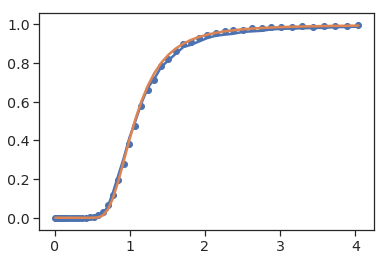

In [1394]:
signal = 1/Rvals
bias = (Rb**2).sum()/(Ra**2).sum()-1
overlap = 0
plt.scatter(Rvals, errs)
plt.plot(Rvals, H(hs.mean(-1)/hs.std(-1)))
# plt.plot(Rvals, H(SNR(signal,bias,Ds,overlap,m)))
plt.plot(Rvals, H(1/2*(signal + bias/m) / np.sqrt(1/Ds + 1/Ds/2 + (Rb**2).sum()/(Ra**2).sum()/Db/2 - 1/D + overlap)))

In [1398]:
M = 500
A = random.randn(M,N)
A.sum()**2

6137.171063595214

In [1207]:
P = 5000
N = 1000
D = 50
m = 1

errs = []
hs = []
Ds = []
Rs = np.linspace(1,20,50)
Rvals = []
alphas = np.linspace(0.01,1,20)
for alpha in alphas:
    Ra = np.arange(1,D+1)**(-alpha)
    Ra /= np.sqrt(np.sum(Ra**2))
    Ra *= 5
    Rb = np.arange(1,D+1)**(-alpha)
    Rb /= np.sqrt(np.sum(Rb**2))
    Rb *= 5
    Ds.append((Ra**2).sum()**2 / (Ra**4).sum())
    err, h = few_shot_err(N,D,P,m,Ra,Rb)
    errs.append(err)
    hs.append(h)
    Rvals.append(np.mean(Ra**2))
Ds = np.stack(Ds)
Rvals = np.stack(Rvals)
hs = np.stack(hs)

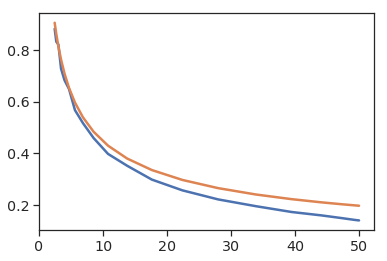

In [848]:
plt.plot(Ds,hs.std(-1))
plt.plot(Ds,2*Rvals*np.sqrt(1/Ds + 1/Ds - 1/N))

In [213]:
Ra = np.arange(1,D+1)**(-alpha)
Ra /= np.sqrt(np.sum(Ra**2))

DeviceArray(0.47320002, dtype=float32)

In [1070]:
m = 1
N = 500
P = 10000

ms = np.arange(1,20)
variances = []
for m in tqdm(ms):
    Ra = np.arange(1,N+1)**(-alpha)
    Ra /= np.sqrt(np.sum(Ra**2))
    Ra *= 1000

    s = random.randn(m,P,N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    variances.append(np.var((s.mean(0)**2@Ra**2)))

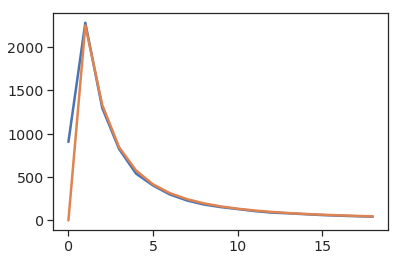

In [1083]:
plt.plot(variances)
plt.plot(18000*ms*(ms-1)/ms**4)
# plt.yscale('log')
# plt.xscale('log')

In [1050]:
np.var((s**2@Ra**2).mean(0))

DeviceArray(881.2324, dtype=float32)

(array([  17.,  391., 1800., 3158., 2764., 1298.,  437.,   99.,   31.,
           5.]),
 array([22.569422, 23.185575, 23.80173 , 24.417883, 25.034037, 25.650188,
        26.266342, 26.882496, 27.49865 , 28.114803, 28.730957],
       dtype=float32),
 <a list of 10 Patch objects>)

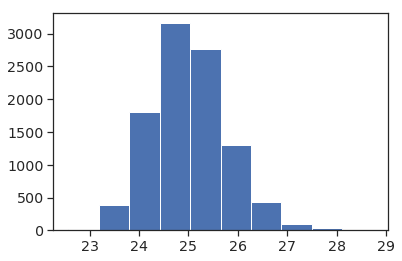

In [1043]:
plt.hist((s**2@Ra**2).mean(0)**2)

(array([  30.,  341., 1347., 2691., 2979., 1774.,  654.,  154.,   25.,
           5.]),
 array([23.888834, 24.151878, 24.414923, 24.677967, 24.941011, 25.204056,
        25.467102, 25.730146, 25.99319 , 26.256235, 26.51928 ],
       dtype=float32),
 <a list of 10 Patch objects>)

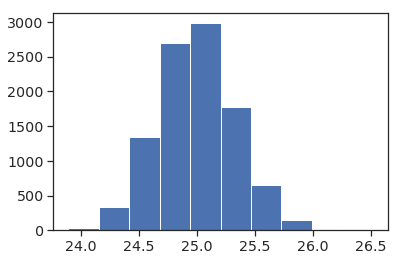

In [1041]:
plt.hist((s**2@Ra**2).mean(0)**2)

## Different dimensions

In [1300]:
P = 5000
N = 200
D = 50
m = 1

errs = []
hs = []
Ds = []
Rs = np.linspace(1,20,50)
Rvals = []
alpha = 0.5
alphab = 0.5
for R in Rs:
    Ra = np.arange(1,D+1)**(-alpha)
    Ra /= np.sqrt(np.sum(Ra**2))
    Ra *= R
    Rb = np.arange(1,D+1)**(-alpha)
    Rb /= np.sqrt(np.sum(Rb**2))
    Rb *= R
    Ds.append((Ra**2).sum()**2 / (Ra**4).sum())
    err, h = few_shot_err(N,D,P,m,Ra,Rb)
    errs.append(err)
    hs.append(h)
    Rvals.append(np.mean(Ra**2))
Ds = np.stack(Ds)
Rvals = np.stack(Rvals)
hs = np.stack(hs)

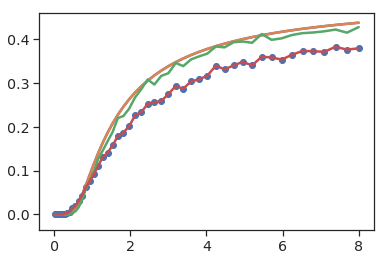

In [1305]:
signal = 1/Rvals
bias = 0
overlap = 0
plt.scatter(Rvals, errs)
plt.plot(Rvals, H(SNR(signal,bias,Ds,overlap,m)))
plt.plot(Rvals, H(1/(2*Rvals)/np.sqrt(1/Ds.mean() + 1/Ds.mean() )))
plt.plot(Rvals, H(hs.mean(-1)/hs.std(-1)))
plt.plot(Rvals, (hs < 0).mean(-1))

In [1404]:
(Ra**2).sum()**2 / (Ra**4).sum()

DeviceArray(52.834923, dtype=float32)

In [1597]:
((Ra**4)@ssa**4).mean()

DeviceArray(0.9120558, dtype=float32)

In [1644]:
m = 5

ms = np.arange(1,30)
variances = []
moments = []
means = []
for m in tqdm(ms):
    sa = random.randn(D,P,m) / np.sqrt(D)
#     sa /= np.linalg.norm(sa,axis=0)

    ssa = random.randn(D,P) / np.sqrt(D)
#     ssa /= np.linalg.norm(ssa,axis=0)
    
    means.append(np.mean(Ra**2@sa.mean(-1)**2))
    moments.append(np.mean((Ra**2@sa.mean(-1)**2)**2))
    variances.append(np.var(Ra**2@sa.mean(-1)**2))

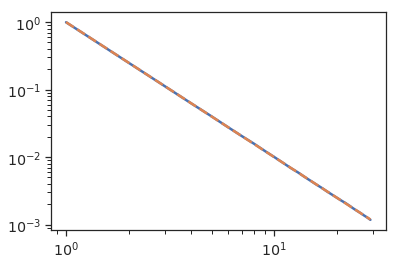

In [1645]:
plt.plot(ms,np.stack(means)**2 / (Ra**2).mean()**2)
plt.plot(ms,1/ms**2, linestyle='dashed')
plt.yscale('log')
plt.xscale('log')

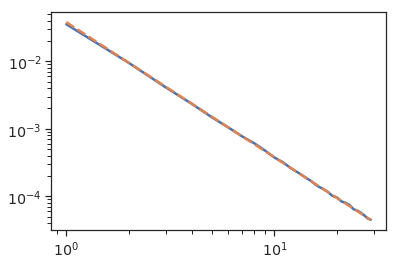

In [1647]:
plt.plot(ms, np.stack(variances) / (Ra**2).mean()**2 )
plt.plot(ms,2/ms**2/Ds.mean(), linestyle='dashed')
# plt.plot(ms, 1/ms**2 , linestyle='dashed')
# plt.plot(ms,1/ms**2/Ds.mean())
plt.yscale('log')
plt.xscale('log')

# ResNet geometry

In [7]:
model_dir = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/resnet50/'

In [45]:
Rs = np.load(model_dir + 'Rs.npy')

In [46]:
centers = np.load(model_dir + 'centers.npy')

In [47]:
from scipy.spatial.distance import squareform, pdist
dx0 = squareform(pdist(centers))

In [48]:
dx0 /= np.sqrt((Rs**2).mean())
Rs /= np.sqrt((Rs**2).mean())

(array([7.06200e+03, 3.28780e+04, 8.33080e+04, 1.96276e+05, 3.10044e+05,
        2.51106e+05, 9.72560e+04, 1.93840e+04, 1.59600e+03, 9.00000e+01]),
 array([2.1317345e-03, 2.8817558e-01, 5.7421947e-01, 8.6026329e-01,
        1.1463071e+00, 1.4323510e+00, 1.7183949e+00, 2.0044386e+00,
        2.2904825e+00, 2.5765264e+00, 2.8625703e+00], dtype=float32),
 <a list of 10 Patch objects>)

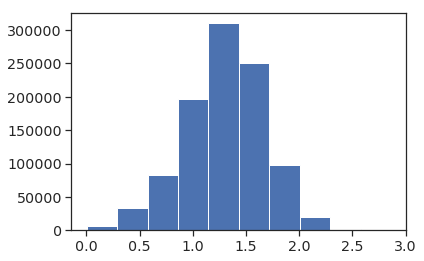

In [49]:
mask = np.eye(1000,dtype='bool')
plt.hist(dx0[~mask]**2)

(array([  9.,  82., 167., 235., 193., 146., 110.,  45.,   9.,   4.]),
 array([0.4436033 , 0.57610726, 0.70861125, 0.84111524, 0.9736192 ,
        1.1061232 , 1.2386272 , 1.3711311 , 1.503635  , 1.636139  ,
        1.768643  ], dtype=float32),
 <a list of 10 Patch objects>)

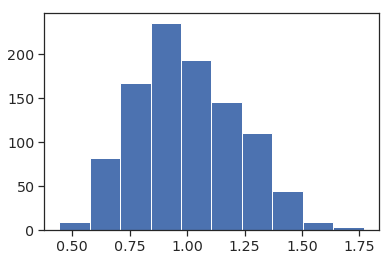

In [50]:
mask = np.eye(1000,dtype='bool')
plt.hist((Rs**2).mean(-1))